# Conditional GANs
Objective:


1.   Test if two conditions, one descrete and one continuos can be imposed to specify the outcome of GANs. 
2.   How does the result compare to the ones from single condition experiment?
3.   How does different conditioning method impact the outcome? 



In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, concatenate
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
import keras.models as models
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Lambda
from keras import backend as K

import matplotlib.pyplot as plt

import numpy as np

## Loading Data

In [2]:
import pickle    
# To recover
with open('./drive/MyDrive/X_rotated.pickle', 'rb') as handle:
    X_rotated = pickle.load(handle)
with open('./drive/MyDrive/y_rotated.pickle', 'rb') as handle:
    y_rotated = pickle.load(handle)
with open('./drive/MyDrive/y_rotations.pickle', 'rb') as handle:
    y_rotations = pickle.load(handle)
# Configure input
X_train = (X_rotated.astype(np.float32) -127.5)/ 127.5 # rescaling to (-1, 1)

X_train = np.expand_dims(X_train, axis=3)
y_train = y_rotated.reshape(-1, 1).astype(np.int32)
y_rotations = y_rotations.reshape(-1,1).astype(np.float32)

In [12]:
y_rotations[0:8]

array([[  0.],
       [ 45.],
       [ 90.],
       [135.],
       [180.],
       [225.],
       [270.],
       [315.]], dtype=float32)

In [3]:
def gen_image(arr):
    """
    convert idstribution from (0,1) to (0, 255), 
    the original scale for visualization
    """
    arr = np.array(arr)
    h, w = arr.shape[0], arr.shape[1]
    two_d = (np.reshape(arr, (h, w)) * 255).astype(np.uint8)
    img = Image.fromarray(two_d)
    return img

In [5]:
### data preview ###
#plt.hist(X_train[0].reshape((28*28)))
from PIL import Image, ImageOps
i = 6
print(y_train[i], y_rotations[i], len(y_train))
gen_image(X_train[i])

[5] [270.] 480000


## Descere + Continuous
Test whether we can impose two condtions, one descrete and one continuous (digit + Rotation)

Here we use **Embedding multiplication** method and **concatenation** method.  

The following uses combination of both. For descrete conditions, **Embedding** is used, for continuous conditions, **Concatenation** is used.

In [5]:
class CGAN_Desc_Cont():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.num_classes2 = 2
        self.latent_dim = 100
        self.X_train = X_train
        self.y_train = y_train
        self.y_rotations = y_rotations

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise, the target label, and the rotation as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        rotation = Input(shape=(1,))
        img = self.generator([noise, label, rotation])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label and rotation of that image
        valid = self.discriminator([img, label, rotation])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label, rotation], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=Adam(0.0001, 0.75))

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim+1)) # Need to expand for added condition
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        rotation = Input(shape=(1,), dtype='float32')

        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
        #rotation_embedding = Flatten()(Embedding(self.num_classes2, self.latent_dim)(rotation))

        model_input = multiply([noise, label_embedding])
        model_input1 = concatenate([model_input, rotation])

        img = model(model_input1)

        return Model([noise, label, rotation], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)+1)) # Need +1 for added condition
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')
        rotation = Input(shape=(1,), dtype='float32')
        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        #rotation_embedding = Flatten()(Embedding(self.num_classes2, np.prod(self.img_shape))(rotation))

        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])
        model_input1 = concatenate([model_input, rotation])

        validity = model(model_input1)

        return Model([img, label, rotation], validity)

    def train(self, epochs, batch_size=32, sample_interval=500):

        # Load the dataset
        X_train = self.X_train
        y_train = self.y_train
        y_train_1 = self.y_rotations
        num_rotation_per_img = 8

        angles = [45*i for i in range(num_rotation_per_img)]

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels, rotations = X_train[idx], y_train[idx], y_train_1[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels, rotations])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels, rotations], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels, rotations], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Conditions
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1) # digit specification
            sampled_labels1 = np.random.choice(angles, batch_size).reshape(-1, 1) # rotation specification

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels, sampled_labels1], valid)

            # Plot the progress
            # print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)

    def sample_images(self, epoch, sampled_labels = np.arange(0, 10).reshape(-1, 1), sampled_labels1 = np.array([36*i for i in range(10)]) ):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        #sampled_labels = np.arange(0, 10).reshape(-1, 1)
        gen_imgs = self.generator.predict([noise, sampled_labels, sampled_labels1])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0],cmap= 'gray' ) #cmap='binary'
                axs[i,j].set_title("Digit: %d" % sampled_labels[cnt]+'\n'+'Rotate: %d'% sampled_labels1[cnt])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("./%d.png" % epoch)
        plt.show()
        plt.close()


# if __name__ == '__main__':
#     cgan = CGAN()
#     cgan.train(epochs=20000, batch_size=32, sample_interval=200)

In [6]:
cgan = CGAN_Desc_Cont()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               402432    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0

In [ ]:
cgan.train(epochs=20000, batch_size=128, sample_interval=4000)

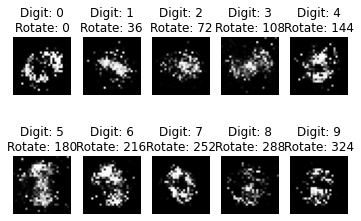

In [ ]:
# For prediction
cgan.sample_images(0,np.array(range(10)).reshape(-1,1), np.array([36*i for i in range(10)]).reshape(-1,1))

In [ ]:
# Save Model
cgan.save('cgan_desc_cont')
#reconstructed_gen = models.load_model("cgan_gen")

## **Concat** + **Concat** 
Try using concatenation for both of the conditions.


In [16]:
class CGAN_Desc_Cont_ver2():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.num_classes2 = 2
        self.latent_dim = 100
        self.X_train = X_train
        self.y_train = y_train
        self.y_rotations = y_rotations

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise, the target label, and the rotation as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(self.num_classes,))
        rotation = Input(shape=(1,))
        img = self.generator([noise, label, rotation])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label and rotation of that image
        valid = self.discriminator([img, label, rotation])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label, rotation], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=Adam(0.0001, 0.75))

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim + self.num_classes+1)) # Need to expand for added condition
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(self.num_classes,), dtype='float32')
        rotation = Input(shape=(1,), dtype='float32')


        #model_input = multiply([noise, label_embedding])
        model_input = concatenate([noise, label, rotation])

        img = model(model_input)

        return Model([noise, label, rotation], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)+self.num_classes + 1,name = 'DENSE1' )) # Need dim for added condition
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512, name= 'DENSE2' ))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(self.num_classes,), dtype='float32')
        rotation = Input(shape=(1,), dtype='float32')
        #label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        #rotation_embedding = Flatten()(Embedding(self.num_classes2, np.prod(self.img_shape))(rotation))

        flat_img = Flatten()(img)

        #model_input = multiply([flat_img, label_embedding])
        model_input = concatenate([flat_img, label, rotation])

        validity = model(model_input)

        return Model([img, label, rotation], validity)

    def train(self, epochs, batch_size=32, sample_interval=500):

        # Load the dataset
        X_train = self.X_train
        #y_train = self.y_train
        y_train = to_categorical(self.y_train, self.num_classes)
        y_train_1 = self.y_rotations
        num_rotation_per_img = 8

        angles = [45*i for i in range(num_rotation_per_img)]

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels, rotations = X_train[idx], y_train[idx], y_train_1[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels, rotations])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels, rotations], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels, rotations], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Conditions
            sampled_labels = labels # np.random.randint(0, 10, batch_size).reshape(-1, 1) # digit specification
            sampled_labels1 = rotations #np.random.choice(angles, batch_size).reshape(-1, 1) # rotation specification

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels, sampled_labels1], valid)

            # Plot the progress
            # print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)

    def sample_images(self, epoch, sampled_labels = np.arange(0, 10).reshape(-1, 1), sampled_labels1 = np.array([36*i for i in range(10)]), test = False):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        if test == False:
            sampled_labels_OH = to_categorical(sampled_labels)
        else:
            sampled_labels_OH = sampled_labels
        gen_imgs = self.generator.predict([noise, sampled_labels_OH, sampled_labels1])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0],cmap= 'gray' ) #cmap='binary'
                axs[i,j].set_title("Digit: %d" % cnt+'\n'+'Rotate: %d'% sampled_labels1[cnt])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("./%d.png" % epoch)
        plt.show()
        plt.close()


# if __name__ == '__main__':
#     cgan = CGAN()
#     cgan.train(epochs=20000, batch_size=32, sample_interval=200)

In [17]:
cgan2 = CGAN_Desc_Cont_ver2()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DENSE1 (Dense)               (None, 512)               407552    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
DENSE2 (Dense)               (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)              

0 [D loss: 4.416128, acc.: 25.78%] [G loss: 1.941483]


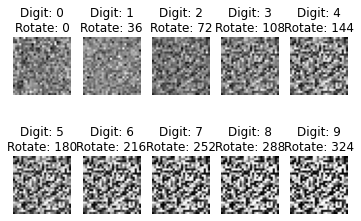

5000 [D loss: 0.481645, acc.: 77.34%] [G loss: 2.167097]


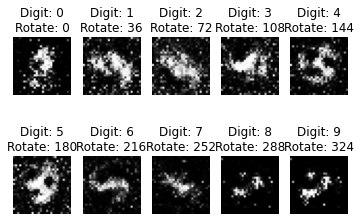

10000 [D loss: 0.357219, acc.: 84.38%] [G loss: 2.142412]


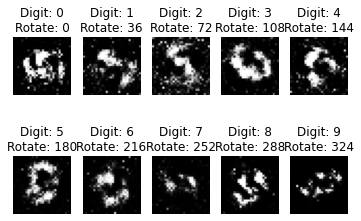

15000 [D loss: 0.430590, acc.: 83.59%] [G loss: 1.929752]


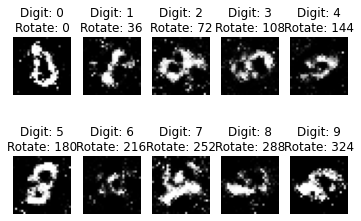

20000 [D loss: 0.468873, acc.: 76.56%] [G loss: 1.711461]


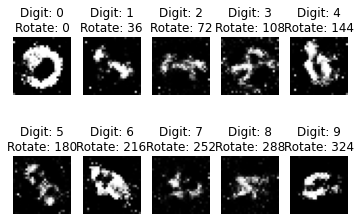

25000 [D loss: 0.448399, acc.: 78.91%] [G loss: 1.657958]


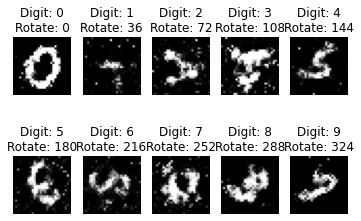

30000 [D loss: 0.438106, acc.: 75.78%] [G loss: 1.680624]


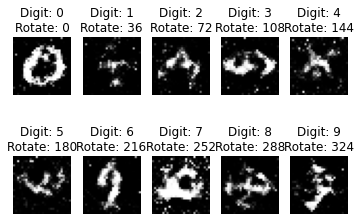

35000 [D loss: 0.419423, acc.: 82.03%] [G loss: 1.927739]


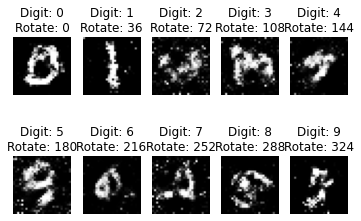

40000 [D loss: 0.385318, acc.: 86.72%] [G loss: 1.649251]


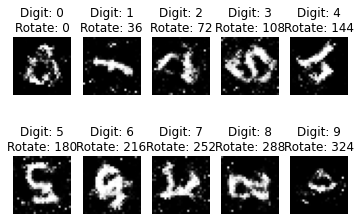

45000 [D loss: 0.470662, acc.: 75.78%] [G loss: 1.639289]


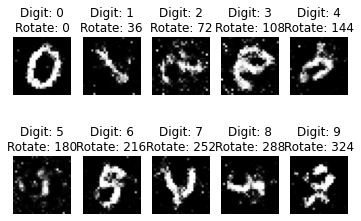

In [18]:
cgan2.train(epochs=50000, batch_size=64, sample_interval=5000)

In [ ]:
cgan2.sample_images(0, sampled_labels = np.arange(0, 10).reshape(-1, 1), sampled_labels1 = np.array([i*25 for i in range(10)]) )

In [ ]:
cgan2.sample_images(0, sampled_labels = np.arange(0, 10).reshape(-1, 1), sampled_labels1 = np.random.rand(10)*1000)

# Testing for Disentanglement
To test whether the model has learned the two conditions separately, we mute one of the conditions i.e. replace it with some radom noise while keeping the other condition, we observe if the imposed condition is considerd or not. If the model simple memorised the combination of the two conditions, replacing it with something it has not seen during the training would result in some random output. 

First, only specify the digit. The rotation will be selected at random number that were NOT using in the training. i.e. out of range, 360+

In [4]:
cgan2.sample_images(0, sampled_labels = np.arange(0, 10).reshape(-1, 1), sampled_labels1 = np.array([-100 for i in range(10)]).reshape(-1,1))

NameError: ignored

In [73]:
# Save the generator model
#cgan2.generator.save('./drive/MyDrive/cGan_digit_rotate_gen')

INFO:tensorflow:Assets written to: ./drive/MyDrive/cGan_digit_rotate_gen/assets


In [5]:
# Recover model 
from tensorflow import keras
cgan2_gen = keras.models.load_model('./drive/MyDrive/cGan_digit_rotate_gen')
cgan2_gen.compile(loss=['binary_crossentropy'],optimizer=Adam(0.0001, 0.75))

In [6]:
def sample_images(gen_model, epoch, sampled_labels = np.arange(0, 10).reshape(-1, 1), sampled_labels1 = np.array([36*i for i in range(10)]), test = False):
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    if test == False:
        sampled_labels_OH = to_categorical(sampled_labels)
    else:
        sampled_labels_OH = sampled_labels
    gen_imgs = gen_model.predict([noise, sampled_labels_OH, sampled_labels1])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt,:,:,0],cmap= 'gray' ) #cmap='binary'
            axs[i,j].set_title(str(cnt) + '\n' + 'Rotate: %d'% sampled_labels1[cnt])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("./%d.png" % epoch)
    plt.show()
    plt.close()

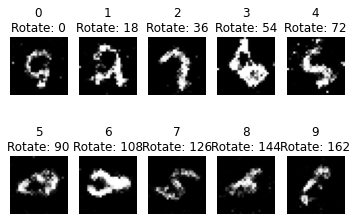

In [20]:
sample_images(cgan2_gen, 0, sampled_labels = np.random.rand(10, 10)*1, sampled_labels1 = np.array([18*i for i in range(10)]), test = True)

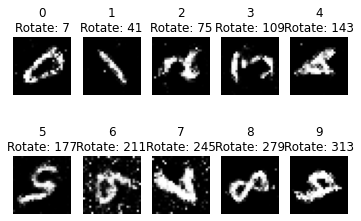

In [16]:
sample_images(cgan2_gen, 1, sampled_labels = np.arange(0, 10).reshape(-1, 1), sampled_labels1 = np.array([34*i+7 for i in range(10)]))

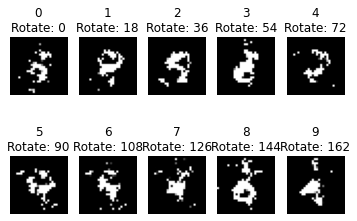

In [9]:
sample_images(cgan2_gen, 0, sampled_labels = np.random.rand(10, 10)*10, sampled_labels1 = np.array([18*i for i in range(10)]), test = True)

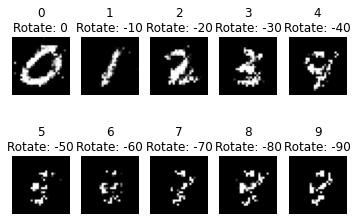

In [10]:
sample_images(cgan2_gen, 2, sampled_labels = np.arange(0, 10).reshape(-1, 1), sampled_labels1 = np.array([-10*i for i in range(10)]))

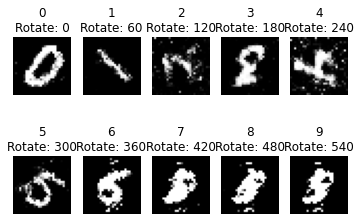

In [11]:
sample_images(cgan2_gen, 2, sampled_labels = np.arange(0, 10).reshape(-1, 1), sampled_labels1 = np.array([60*i for i in range(10)]))

In [57]:


def OneHot(input_dim=None, input_length=None):
    # Check if inputs were supplied correctly
    if input_dim is None or input_length is None:
        raise TypeError("input_dim or input_length is not set")

    # Helper method (not inlined for clarity)
    def _one_hot(x, num_classes):
        return K.one_hot(K.cast(x, 'uint8'),
                          num_classes=num_classes)

    # Final layer representation as a Lambda layer
    return Lambda(_one_hot,
                  arguments={'num_classes': input_dim},
                  input_shape=(input_length,))

In [ ]:
# For pickleing
import pickle
# with open('cgan_gen_weights.pickle', 'wb') as handle:
#     pickle.dump(cgan.generator.weights, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# To recover
# with open('cgan_gen_weights.pickle', 'rb') as handle:
#     recovered_weights = pickle.load(handle)